In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytube # สำหรับการ Download เสียงจาก youtube
!pip install pydub # สำหรับการจัดการและการประมวลผลไฟล์เสีย

In [ ]:
# prompt: gdown zip file on gdrive

!gdown --id 1yDZr-CGoc0u51SuR12nTdAJOCyD9mRly -O /content/DSTHAI.zip


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1yDZr-CGoc0u51SuR12nTdAJOCyD9mRly
From (redirected): https://drive.google.com/uc?id=1yDZr-CGoc0u51SuR12nTdAJOCyD9mRly&confirm=t&uuid=1cf2be30-be1b-44b3-8fb8-6e0a22e31f1a
To: /content/DSTHAI.zip
100% 400M/400M [00:02<00:00, 145MB/s]


In [ ]:
# prompt: unzip file

!unzip /content/DSTHAI.zip -d /content/DSTHAI


Archive:  /content/DSTHAI.zip
   creating: /content/DSTHAI/content/DSTHAI/
   creating: /content/DSTHAI/content/DSTHAI/tack14/
  inflating: /content/DSTHAI/content/DSTHAI/tack14/flute.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack14/mixed_original.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack14/mixed_with_pitch_shift.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack14/xylophone.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack14/mixed_with_speed_change.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack14/fiddle.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack14/mixed_with_noise.mp3  
   creating: /content/DSTHAI/content/DSTHAI/tack90/
  inflating: /content/DSTHAI/content/DSTHAI/tack90/flute.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack90/mixed_original.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack90/mixed_with_pitch_shift.mp3  
  inflating: /content/DSTHAI/content/DSTHAI/tack90/xylophone.mp3  
  inflating: /content/DSTHAI/content/D

**ส่วนนี้ยังไม่ได้อ่าน**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Conv1DTranspose, Concatenate, Add, Activation, Multiply, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import time
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from pytube import YouTube
from pydub import AudioSegment

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(dataset_path, duration=30):
    tracks = []
    required_files = ['mixed_original.mp3', 'mixed_with_noise.mp3', 'mixed_with_pitch_shift.mp3', 'mixed_with_speed_change.mp3', 'fiddle.mp3', 'flute.mp3', 'xylophone.mp3']

    for folder in os.listdir(dataset_path):
      for mixed_file in ['mixed_original.mp3', 'mixed_with_noise.mp3', 'mixed_with_pitch_shift.mp3', 'mixed_with_speed_change.mp3']:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            files_in_folder = os.listdir(folder_path)
            if all(file in files_in_folder for file in required_files):
                mixture_path = os.path.join(folder_path, mixed_file)
                fiddle_path = os.path.join(folder_path, 'fiddle.mp3')
                flute_path = os.path.join(folder_path, 'flute.mp3')
                xylophone_path = os.path.join(folder_path, 'xylophone.mp3')

                mixture, sr = librosa.load(mixture_path, sr=None, duration=duration)
                fiddle, _ = librosa.load(fiddle_path, sr=sr, duration=duration)
                flute, _ = librosa.load(flute_path, sr=sr, duration=duration)
                xylophone, _ = librosa.load(xylophone_path, sr=sr, duration=duration)

                if len(mixture) == duration * sr and len(fiddle) == duration * sr and len(flute) == duration * sr and len(xylophone) == duration * sr:
                    mixture = mixture.reshape(-1, 1)
                    instruments = np.stack([fiddle, flute, xylophone], axis=-1)
                    tracks.append((mixture, instruments))
    return tracks, sr

dataset_path = '/content/DSTHAI/content/DSTHAI'
tracks, sample_rate = load_data(dataset_path)




In [ ]:
def split_dataset(tracks, split_ratio=0.8):
    train_tracks, val_tracks = train_test_split(tracks, train_size=split_ratio, random_state=42)
    return train_tracks, val_tracks
train_tracks, val_tracks = split_dataset(tracks, split_ratio=0.8)

Total tracks: 384
Training tracks: 307
Validation tracks: 77


In [ ]:
def data_generator(tracks, batch_size):
    while True:
        for start in range(0, len(tracks), batch_size):
            end = min(start + batch_size, len(tracks))
            batch_tracks = tracks[start:end]

            mixtures = np.array([track[0] for track in batch_tracks])
            instruments = np.array([track[1] for track in batch_tracks])

            yield mixtures, instruments

batch_size = 12
train_generator = data_generator(train_tracks, batch_size)
val_generator = data_generator(val_tracks, batch_size)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Conv1DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

def create_wave_unet_model(input_shape):
    def downsampling_block(x, filters, kernel_size, pool_size):
        conv = Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
        downsampled = MaxPooling1D(pool_size)(conv)
        return downsampled, conv

    def upsampling_block(x, skip_connection, filters, kernel_size, upsample_size):
        upsampled = Conv1DTranspose(filters, kernel_size, strides=upsample_size, activation='relu', padding='same', kernel_initializer=he_normal())(x)
        concat = Concatenate()([upsampled, skip_connection])
        return concat

    inputs = Input(shape=input_shape)
    skip_connections = []
    x = inputs

    # Downsampling blocks
    for filters in [64, 128, 256]:
        x, skip = downsampling_block(x, filters, 15, 2)
        skip_connections.append(skip)

    # Bottleneck
    x = Conv1D(512, 15, activation='relu', padding='same')(x)

    # Upsampling blocks
    for filters, skip in zip([256, 128, 64], reversed(skip_connections)):
        x = upsampling_block(x, skip, filters, 5, 2)

    outputs = Conv1D(3, 1, activation='linear', padding='same')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (None, 1)
model = create_wave_unet_model(input_shape)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=adam_optimizer, loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 64)             1024      ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, None, 64)             0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, None, 128)            123008    ['max_pooling1d[0][0]']   

In [ ]:
# prompt: เก็บค่า Epoch Number, Training Loss, MSAE, Learning Rate, Elapsed Time, RAM, CPU ในทุกๆ1epoch ให้เก็บเป็น csv โดยให้ Ram และ cpu เก็บเป็นหน่วย  Gb ทำเป็น callback
import tensorflow as tf
import os
import time
import csv
import resource
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

class keepDataCSV(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        self.save_path = save_path
        self.csv_file = open(os.path.join(save_path, 'training_stats.csv'), 'w')
        self.csv_writer = csv.writer(self.csv_file)
        self.csv_writer.writerow(['Epoch Number', 'Training Loss', 'Validate Loss', 'MAE', 'Validate MAE', 'Learning Rate', 'Elapsed Time', 'RAM', 'CPU'])

    def on_train_begin(self, logs=None):
        # Record the start time when training begins
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        # Calculate RAM and CPU usage
        ram_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024 ** 2
        cpu_usage = resource.getrusage(resource.RUSAGE_SELF).ru_utime + resource.getrusage(resource.RUSAGE_SELF).ru_stime

        # Write epoch data to CSV
        self.csv_writer.writerow([epoch + 1, logs.get('loss'), logs.get('val_loss'), logs.get('mean_absolute_error'), logs.get('val_mean_absolute_error'),
                                  logs.get('lr'), time.time() - self.start_time, ram_usage, cpu_usage])
        self.csv_file.flush()

# Create the callback object
save_path = '/content/ModelComplete'
keepDataCSV = keepDataCSV(save_path)
# Callbacks


# Define callbacks
checkpoint = ModelCheckpoint('/content/ModelComplete/model_{epoch:02d}.h5', save_freq='epoch', period=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

epochs = 20 # Adjust as needed
steps_per_epoch = len(tracks) // batch_size
validation_steps = len(val_tracks) // batch_size

model.fit(train_generator, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint, keepDataCSV],
          steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=validation_steps)

keepDataCSV.csv_file.close()


In [ ]:
# prompt: zip folder to drive

!zip -r /content/ModelComplete.zip /content/ModelComplete
!cp /content/ModelComplete.zip /content/drive/MyDrive/


  adding: content/ModelComplete/ (stored 0%)
  adding: content/ModelComplete/model_30.h5 (deflated 9%)
  adding: content/ModelComplete/training_stats.csv (deflated 18%)
  adding: content/ModelComplete/training_stats_continues.csv (deflated 46%)


In [ ]:
# prompt: disconnect runtime

!kill -9 -1


In [ ]:
# for start_epoch in range(10, 50, 1):
#     # โหลดโมเดลจาก checkpoint ล่าสุด
#     model = load_model(f'model_{start_epoch:02d}.h5')
#     # เทรนต่ออีก 10 epoch
#     model.fit(train_generator, epochs=start_epoch+1, initial_epoch=start_epoch, callbacks=[early_stopping, lr_scheduler, checkpoint, custom_callback],  steps_per_epoch=steps_per_epoch)


# custom_callback.csv_file.close()

OSError: No file or directory found at model_10.h5

In [ ]:
model.save('SD.h5')

In [ ]:
model = tf.keras.models.load_model('SD.h5')

# Load Model

## Model 50

In [ ]:
!mkdir /content/TrainComplete50

In [ ]:
!gdown --id 162zPGaAA_8Bw9YhVpyvhQBRL_JZwJOZ8 -O /content/TrainComplete50/ModelComplete50.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=162zPGaAA_8Bw9YhVpyvhQBRL_JZwJOZ8
From (redirected): https://drive.google.com/uc?id=162zPGaAA_8Bw9YhVpyvhQBRL_JZwJOZ8&confirm=t&uuid=e50b43ca-2de3-4437-b152-49569efc490c
To: /content/TrainComplete50/ModelComplete50.zip
100% 207M/207M [00:02<00:00, 84.8MB/s]


In [ ]:
!unzip /content/TrainComplete50/ModelComplete50.zip -d /content/TrainComplete50

Archive:  /content/TrainComplete50/ModelComplete50.zip
   creating: /content/TrainComplete50/content/ModelComplete/
  inflating: /content/TrainComplete50/content/ModelComplete/model_30.h5  
  inflating: /content/TrainComplete50/content/ModelComplete/model_40.h5  
  inflating: /content/TrainComplete50/content/ModelComplete/training_stats.csv  
  inflating: /content/TrainComplete50/content/ModelComplete/model_10.h5  
  inflating: /content/TrainComplete50/content/ModelComplete/model_20.h5  
  inflating: /content/TrainComplete50/content/ModelComplete/model_50.h5  


## Model 20

In [ ]:
!mkdir /content/TrainComplete20

In [ ]:
!gdown --id 1GLAdQ6IfEemTtY4wS7APz1GTEN_u2pcB -O /content/TrainComplete20/ModelComplete20.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GLAdQ6IfEemTtY4wS7APz1GTEN_u2pcB
From (redirected): https://drive.google.com/uc?id=1GLAdQ6IfEemTtY4wS7APz1GTEN_u2pcB&confirm=t&uuid=1bd3a467-4b49-4e4b-b914-00b4af61ef67
To: /content/TrainComplete20/ModelComplete20.zip
100% 83.2M/83.2M [00:01<00:00, 80.5MB/s]


In [ ]:
# prompt: unzip file

!unzip /content/TrainComplete20/ModelComplete20.zip -d /content/TrainComplete20

Archive:  /content/TrainComplete20/ModelComplete20.zip
   creating: /content/TrainComplete20/content/ModelComplete/
  inflating: /content/TrainComplete20/content/ModelComplete/model_10.h5  
  inflating: /content/TrainComplete20/content/ModelComplete/model_20.h5  
  inflating: /content/TrainComplete20/content/ModelComplete/training_stats.csv  


## Model 10

In [ ]:
!mkdir /content/TrainComplete10

In [ ]:
!gdown --id 1CF_qLpaEysCdFAIE9pmKQhDbkk4X08L5 -O /content/TrainComplete10/ModelComplete10.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CF_qLpaEysCdFAIE9pmKQhDbkk4X08L5
From (redirected): https://drive.google.com/uc?id=1CF_qLpaEysCdFAIE9pmKQhDbkk4X08L5&confirm=t&uuid=40280c99-28d7-476a-bd11-f4d6d70cf4ab
To: /content/TrainComplete10/ModelComplete10.zip
100% 40.8M/40.8M [00:00<00:00, 187MB/s]


In [ ]:
# prompt: unzip file

!unzip /content/TrainComplete10/ModelComplete10.zip -d /content/TrainComplete10

Archive:  /content/TrainComplete10/ModelComplete10.zip
   creating: /content/TrainComplete10/content/ModelComplete/
  inflating: /content/TrainComplete10/content/ModelComplete/model_10.h5  
  inflating: /content/TrainComplete10/content/ModelComplete/training_stats.csv  


## Model 20 Round 2

In [ ]:
!mkdir /content/TrainComplete20_round2

In [ ]:
!gdown --id 1qjPgNouJA6SsoKbr4Hs_z0ztje9NNgHq -O /content/TrainComplete20_round2/ModelComplete20.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qjPgNouJA6SsoKbr4Hs_z0ztje9NNgHq
From (redirected): https://drive.google.com/uc?id=1qjPgNouJA6SsoKbr4Hs_z0ztje9NNgHq&confirm=t&uuid=90d691f8-4dfa-41da-899b-ee66f0d82341
To: /content/TrainComplete20_round2/ModelComplete20.zip
100% 83.1M/83.1M [00:01<00:00, 62.4MB/s]


In [ ]:
!unzip /content/TrainComplete20_round2/ModelComplete20.zip -d /content/TrainComplete20_round2

Archive:  /content/TrainComplete20_round2/ModelComplete20.zip
   creating: /content/TrainComplete20_round2/content/ModelComplete/
  inflating: /content/TrainComplete20_round2/content/ModelComplete/model_10.h5  
  inflating: /content/TrainComplete20_round2/content/ModelComplete/model_20.h5  
  inflating: /content/TrainComplete20_round2/content/ModelComplete/training_stats.csv  


## Model 20 Round 3

In [ ]:
!mkdir /content/TrainComplete20_round3

In [ ]:
!gdown --id 1UyeF6TZ5YGJW16LMv2k6qacyUde_9B_P -O /content/TrainComplete20_round3/ModelComplete20.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UyeF6TZ5YGJW16LMv2k6qacyUde_9B_P
From (redirected): https://drive.google.com/uc?id=1UyeF6TZ5YGJW16LMv2k6qacyUde_9B_P&confirm=t&uuid=d7c3212a-c1c6-47c4-8190-f59af1d36424
To: /content/TrainComplete20_round3/ModelComplete20.zip
100% 124M/124M [00:00<00:00, 145MB/s]


In [ ]:
!unzip /content/TrainComplete20_round3/ModelComplete20.zip -d /content/TrainComplete20_round3

Archive:  /content/TrainComplete20_round3/ModelComplete20.zip
   creating: /content/TrainComplete20_round3/content/ModelComplete/
  inflating: /content/TrainComplete20_round3/content/ModelComplete/model_15.h5  
  inflating: /content/TrainComplete20_round3/content/ModelComplete/training_stats_continues.csv  
  inflating: /content/TrainComplete20_round3/content/ModelComplete/model_10.h5  
  inflating: /content/TrainComplete20_round3/content/ModelComplete/model_20.h5  
  inflating: /content/TrainComplete20_round3/content/ModelComplete/training_stats.csv  


## Model 30 Round 4

In [ ]:
!mkdir /content/TrainComplete30

In [ ]:
!gdown --id 1TzATNRjkAu6gIi0sN-8OgQAPiQELRcxR -O /content/TrainComplete30/ModelComplete30.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TzATNRjkAu6gIi0sN-8OgQAPiQELRcxR
From (redirected): https://drive.google.com/uc?id=1TzATNRjkAu6gIi0sN-8OgQAPiQELRcxR&confirm=t&uuid=605fb52f-a3fc-4a2a-835c-70b223cc7b11
To: /content/TrainComplete30/ModelComplete30.zip
100% 40.0M/40.0M [00:00<00:00, 110MB/s]


In [ ]:
!unzip /content/TrainComplete30/ModelComplete30.zip -d /content/TrainComplete30

Archive:  /content/TrainComplete30/ModelComplete30.zip
   creating: /content/TrainComplete30/content/ModelComplete/
  inflating: /content/TrainComplete30/content/ModelComplete/model_30.h5  
  inflating: /content/TrainComplete30/content/ModelComplete/training_stats.csv  
  inflating: /content/TrainComplete30/content/ModelComplete/training_stats_continues.csv  


Model 25

In [ ]:
!mkdir /content/TrainComplete25

In [ ]:
!gdown --id 1ngl2SkJlRYg_2ik3xKdkpFFILsxkBwMB -O /content/TrainComplete25/ModelComplete25.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ngl2SkJlRYg_2ik3xKdkpFFILsxkBwMB
From (redirected): https://drive.google.com/uc?id=1ngl2SkJlRYg_2ik3xKdkpFFILsxkBwMB&confirm=t&uuid=9776fd69-e2f6-4d97-aec7-a364fa7bbfa7
To: /content/TrainComplete25/ModelComplete25.zip
100% 41.6M/41.6M [00:00<00:00, 59.8MB/s]


In [ ]:
!unzip /content/TrainComplete25/ModelComplete25.zip -d /content/TrainComplete25

Archive:  /content/TrainComplete25/ModelComplete25.zip
   creating: /content/TrainComplete25/content/ModelComplete/
  inflating: /content/TrainComplete25/content/ModelComplete/training_stats.csv  
  inflating: /content/TrainComplete25/content/ModelComplete/training_stats_continues.csv  
  inflating: /content/TrainComplete25/content/ModelComplete/model_25.h5  


In [ ]:
import pandas as pd

df = pd.read_csv('/content/TrainComplete20_round2/content/ModelComplete/training_stats.csv')
df

,Epoch Number,Training Loss,Validate Loss,MAE,Validate MAE,Learning Rate,Elapsed Time,RAM,CPU
0,1,0.019279,0.012864,0.092457,0.081102,0.005000,1402.592136,80.708115,7.745902e+04
1,2,0.012799,0.012580,0.080379,0.079956,0.005000,2796.579498,81.528000,1.543038e+05
2,3,0.011984,0.012023,0.076914,0.077595,0.005000,4188.151943,81.644436,2.310421e+05
3,4,0.011375,0.012289,0.074096,0.076869,0.005000,5581.541787,81.691711,3.077300e+05
4,5,0.011292,0.012088,0.073533,0.076332,0.005000,6952.046928,81.707874,3.830422e+05
5,6,0.011037,0.011107,0.072553,0.073240,0.005000,8358.870113,81.826157,4.603229e+05
6,7,0.011093,0.011329,0.072360,0.073917,0.005000,9760.467098,82.012222,5.372160e+05
7,8,0.010524,0.011338,0.070235,0.073618,0.005000,11160.962238,82.090591,6.139190e+05
8,9,0.010924,0.011866,0.071636,0.074781,0.005000,12537.811902,82.135838,6.893604e+05
9,10,0.010865,0.011952,0.071472,0.075660,0.005000,13938.354754,82.264702,7.661218e+05


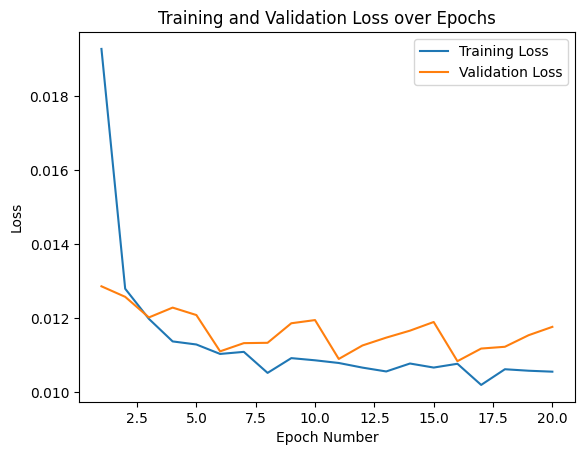

In [ ]:
# @title Training and Validation Loss over Epochs

import matplotlib.pyplot as plt

plt.plot(df['Epoch Number'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch Number'], df['Validate Loss'], label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
_ = plt.legend()

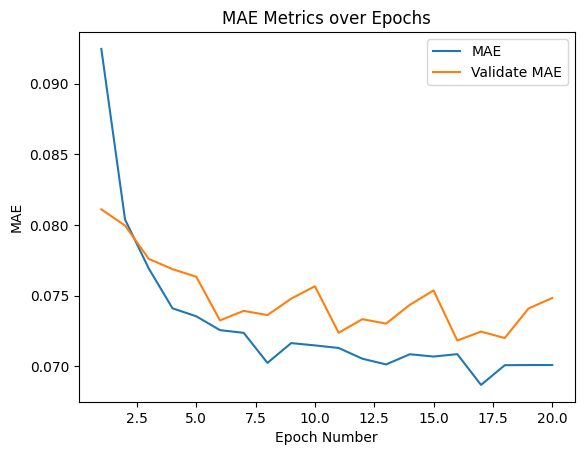

In [ ]:
# @title MAE Metrics over Epochs

import matplotlib.pyplot as plt

plt.plot(df['Epoch Number'], df['MAE'], label='MAE')
plt.plot(df['Epoch Number'], df['Validate MAE'], label='Validate MAE')
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
plt.title('MAE Metrics over Epochs')
_ = plt.legend()


In [ ]:
df = pd.read_csv('/content/TrainComplete20/content/ModelComplete/training_stats.csv')
df

,Epoch Number,Training Loss,MSAE,Learning Rate,Elapsed Time,RAM,CPU
0,1,0.012548,0.078764,0.001000,1521.843668,59.241814,8.379694e+04
1,2,0.011544,0.074817,0.001000,3035.470876,59.850613,1.671690e+05
2,3,0.011047,0.072039,0.001000,4549.033113,60.012199,2.503951e+05
3,4,0.010802,0.071053,0.001000,6067.703746,60.089031,3.335935e+05
4,5,0.010965,0.071649,0.001000,7562.175374,60.089031,4.154703e+05
5,6,0.010794,0.071225,0.001000,9082.807168,60.177628,4.986641e+05
6,7,0.010872,0.071086,0.001000,10602.940712,60.201618,5.818233e+05
7,8,0.010293,0.068955,0.001000,12129.712468,60.260315,6.652238e+05
8,9,0.010704,0.070199,0.001000,13626.607502,60.449467,7.469384e+05
9,10,0.010628,0.070291,0.001000,15146.836801,60.510853,8.301092e+05


In [ ]:
df = pd.read_csv('/content/TrainComplete50/content/ModelComplete/training_stats.csv')
df

,Epoch Number,Training Loss,MSAE,Learning Rate,Elapsed Time,RAM,CPU
0,1,0.012829,0.079386,0.001000,1468.989797,58.812218,8.116466e+04
1,2,0.011630,0.075226,0.001000,2933.280977,59.082401,1.619322e+05
2,3,0.011334,0.073737,0.001000,4400.040174,59.161129,2.426474e+05
3,4,0.011072,0.072440,0.001000,5865.438651,59.217533,3.233545e+05
4,5,0.010986,0.071940,0.001000,7335.014508,59.245476,4.041640e+05
5,6,0.010926,0.071676,0.001000,8801.937501,59.245476,4.849436e+05
6,7,0.010869,0.071405,0.001000,10271.660318,59.255413,5.657355e+05
7,8,0.010813,0.071143,0.001000,11741.994336,59.255413,6.465402e+05
8,9,0.010764,0.070878,0.001000,13212.987042,59.265167,7.273176e+05
9,10,0.010713,0.070642,0.001000,14684.207590,59.267860,8.081150e+05


# **TEST**

In [ ]:
!mkdir /content/separated_audio/

In [ ]:
!pip install pytube # สำหรับการ Download เสียงจาก youtube
!pip install pydub # สำหรับการจัดการและการประมวลผลไฟล์เสีย

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 852.8 kB/s eta 0:00:00


In [ ]:
import soundfile as sf
import os
import tensorflow as tf
import numpy as np
from pytube import YouTube
from pydub import AudioSegment
import librosa

In [ ]:
def download_audio(url, output_path):
    yt = YouTube(url)
    audio_stream = yt.streams.filter(only_audio=True).first()
    output_file = audio_stream.download(output_path=output_path)
    return output_file

def convert_to_mp3(input_file, output_file):
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format="mp3")

In [ ]:
def split_audio(audio_file_path, segment_duration=30 * 1000):
    audio = AudioSegment.from_file(audio_file_path)
    audio_name = os.path.splitext(os.path.basename(audio_file_path))[0]
    for i in range(0, len(audio), segment_duration):
      split_path = f"./DSTHAI/tack{(i // segment_duration) + 1}"
      if not os.path.exists(split_path):
        os.makedirs(split_path)
      segment = audio[i:i + segment_duration]
      segment.export(f"{split_path}/{audio_name}.mp3", format="mp3")

In [ ]:
urls = {
    "https://www.youtube.com/watch?v=iaKlQBPCgH0": "Origin3",
}
output_path = "./youtube_audios"

if not os.path.exists(output_path):
    os.makedirs(output_path)

for url, instrument in urls.items():
    mp4_file = download_audio(url, output_path)
    mp3_file = os.path.join(output_path, f"{instrument}.mp3")
    convert_to_mp3(mp4_file, mp3_file)
    split_audio(mp3_file)

NameError: name 'os' is not defined

In [ ]:
!gdown --id 1c1xDBVqBL-d5kQObgTOYrylSlMGL8h-N

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c1xDBVqBL-d5kQObgTOYrylSlMGL8h-N
To: /content/Mix_แขกบรรเทศ.mp3
100% 1.23M/1.23M [00:00<00:00, 142MB/s]


In [ ]:
!gdown --id 1RaHoRBwza6BmIrI5RBbiFd3cmzpJJ-6X

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RaHoRBwza6BmIrI5RBbiFd3cmzpJJ-6X
To: /content/Mix_เพลงเทส_Mono.mp3
100% 3.74M/3.74M [00:00<00:00, 297MB/s]


In [ ]:
!gdown --id 11j7RxN6EK_i9uD3vd6PeWF4Cpy2Oyumc

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11j7RxN6EK_i9uD3vd6PeWF4Cpy2Oyumc
To: /content/Mix_เพลงเทส_Stereo.mp3
100% 3.74M/3.74M [00:00<00:00, 211MB/s]


In [ ]:
# Specify the path to your file in Google Drive
file_path = '/content/TrainComplete20_round2/content/ModelComplete/model_20.h5'

# Load the model
model = tf.keras.models.load_model(file_path)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 64)             1024      ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, None, 64)             0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, None, 128)            123008    ['max_pooling1d[0][0]']   

In [ ]:
import librosa
# Function to preprocess mixed audio
def preprocess_audio(audio_path, duration, sr):
    audio, _ = librosa.load(audio_path, sr=sr, duration=duration)
    if len(audio) < duration * sr:
        # If the audio is shorter than the expected duration, pad it with zeros
        audio = np.pad(audio, (0, duration * sr - len(audio)))
    audio = audio.reshape(-1, 1)
    return audio

# Function to predict the separated sources
def predict_separation(model, mixed_audio):
    mixed_audio = mixed_audio[np.newaxis, ...]  # Add batch dimension
    predicted_sources = model.predict(mixed_audio)
    return predicted_sources[0]  # Remove batch dimension

# Function to save the separated sources
def save_audio(output_dir, sources, sr):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    instrument_names = ['fiddle', 'flute', 'xylophone']
    for i, instrument in enumerate(instrument_names):
        output_path = os.path.join(output_dir, f'{instrument}.mp3')
        sf.write(output_path, sources[:, i], sr)

# Function to separate audio using the trained model
def separate_audio(model, input_audio_path, output_dir, duration, sr):
    # Load and preprocess the mixed audio
    mixed_audio = preprocess_audio(input_audio_path, duration, sr)

    # Predict the separated sources
    separated_sources = predict_separation(model, mixed_audio)

    # Save the separated sources
    save_audio(output_dir, separated_sources, sr)

# Example usage
input_audio_path = '/content/Mix_เพลงเทส_Stereo.mp3'  # Path to your mixed audio file
output_dir = '/content/separated_audio'  # Directory where you want to save the separated tracks
duration = 30  # seconds
sr = 44100  # sample rate

# Load the trained model

# Separate the audio and save the output
separate_audio(model, input_audio_path, output_dir, duration, sr)

1/1 [==============================] - 2s 2s/step


In [ ]:
from IPython.display import Audio, display

In [ ]:
audio_test_file_path = "/content/Mix_แขกบรรเทศ.mp3"

Audio(audio_test_file_path)

In [ ]:
audio_test_file_path = "/content/separated_audio/flute.mp3"

Audio(audio_test_file_path)

In [ ]:
audio_test_file_path = "/content/separated_audio/fiddle.mp3"

Audio(audio_test_file_path)

In [ ]:
audio_test_file_path = "/content/separated_audio/xylophone.mp3"

Audio(audio_test_file_path)

In [ ]:
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 5.6 MB/s eta 0:00:00
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100704 sha256=79b31f3016f4a5bd1415675efd50b377299a3ed1480dbacde79016257f438d47
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


In [ ]:
import librosa
# Function to preprocess mixed audio
def preprocess_audio(audio_path, duration, sr):
    audio, _ = librosa.load(audio_path, sr=sr, duration=duration)
    if len(audio) < duration * sr:
        # If the audio is shorter than the expected duration, pad it with zeros
        audio = np.pad(audio, (0, duration * sr - len(audio)))
    audio = audio.reshape(-1, 1)
    return audio

# Function to predict the separated sources
def predict_separation(model, mixed_audio):
    mixed_audio = mixed_audio[np.newaxis, ...]  # Add batch dimension
    predicted_sources = model.predict(mixed_audio)
    return predicted_sources[0]  # Remove batch dimension

# Function to save the separated sources
def save_audio(output_dir, sources, sr):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    instrument_names = ['fiddle', 'flute', 'xylophone']
    for i, instrument in enumerate(instrument_names):
        output_path = os.path.join(output_dir, f'{instrument}.mp3')
        sf.write(output_path, sources[:, i], sr)

# Function to separate audio using the trained model
def separate_audio(model, input_audio_path, output_dir, duration, sr):
    # Load and preprocess the mixed audio
    mixed_audio = preprocess_audio(input_audio_path, duration, sr)

    # Predict the separated sources
    separated_sources = predict_separation(model, mixed_audio)

    # Save the separated sources
    save_audio(output_dir, separated_sources, sr)

# Example usage
input_audio_path = '/content/DSTHAI/content/DSTHAI/tack1/mixed_with_noise.mp3'  # Path to your mixed audio file
output_dir = '/content/separated_audio'  # Directory where you want to save the separated tracks
duration = 30  # seconds
sr = 44100  # sample rate

# Load the trained model

# Separate the audio and save the output
separate_audio(model, input_audio_path, output_dir, duration, sr)

1/1 [==============================] - 2s 2s/step


In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import mir_eval
import librosa

# Function to load audio file
def load_audio(file_path):
    data, rate = librosa.load(file_path, sr=None) # Use librosa to load the audio file
    return rate, data

# Function to compute SDR
def compute_sdr(reference_sources, estimated_sources):
    sdr, _, _, _ = mir_eval.separation.bss_eval_sources(reference_sources, estimated_sources)
    return sdr

# Load your mixed audio and separated audio files
mixed_audio_path = '/content/DSTHAI/content/DSTHAI/tack1/mixed_with_noise.mp3'
source1_path = '/content/DSTHAI/content/DSTHAI/tack1/fiddle.mp3'
source2_path = '/content/DSTHAI/content/DSTHAI/tack1/flute.mp3'
source3_path = '/content/DSTHAI/content/DSTHAI/tack1/xylophone.mp3'

# Assuming the model's separated outputs are stored in these files
estimated_source1_path = '/content/separated_audio/fiddle.mp3'
estimated_source2_path = '/content/separated_audio/flute.mp3'
estimated_source3_path = '/content/separated_audio/xylophone.mp3'

# Load audio files
_, mixed_audio = load_audio(mixed_audio_path)
_, true_source1 = load_audio(source1_path)
_, true_source2 = load_audio(source2_path)
_, true_source3 = load_audio(source3_path)
_, estimated_source1 = load_audio(estimated_source1_path)
_, estimated_source2 = load_audio(estimated_source2_path)
_, estimated_source3 = load_audio(estimated_source3_path)

# Combine true and estimated sources into arrays
reference_sources = np.array([true_source1, true_source2, true_source3])
estimated_sources = np.array([estimated_source1, estimated_source2, estimated_source3])

# Compute SDR
sdr_values = compute_sdr(reference_sources, estimated_sources)

print("SDR values for each source:")
for i, sdr in enumerate(sdr_values):
    print(f"Source {i+1}: {sdr:.2f} dB")


SDR values for each source:
Source 1: 11.20 dB
Source 2: 12.46 dB
Source 3: 3.11 dB


# VIR

In [ ]:
# prompt: combine 3 csv

import pandas as pd

# Read the three CSV files
df1 = pd.read_csv('/content/TrainComplete20_round2/content/ModelComplete/training_stats.csv')
df2 = pd.read_csv('/content/TrainComplete25/content/ModelComplete/training_stats_continues.csv')
df3 = pd.read_csv('/content/TrainComplete30/content/ModelComplete/training_stats_continues.csv')
df3 = df3[:-2]
# Combine the three DataFrames
df3 = pd.concat([df1, df2, df3], ignore_index=True)
df3

,Epoch Number,Training Loss,Validate Loss,MAE,Validate MAE,Learning Rate,Elapsed Time,RAM,CPU
0,1,0.019279,0.012864,0.092457,0.081102,0.005000,1402.592136,80.708115,7.745902e+04
1,2,0.012799,0.012580,0.080379,0.079956,0.005000,2796.579498,81.528000,1.543038e+05
2,3,0.011984,0.012023,0.076914,0.077595,0.005000,4188.151943,81.644436,2.310421e+05
3,4,0.011375,0.012289,0.074096,0.076869,0.005000,5581.541787,81.691711,3.077300e+05
4,5,0.011292,0.012088,0.073533,0.076332,0.005000,6952.046928,81.707874,3.830422e+05
5,6,0.011037,0.011107,0.072553,0.073240,0.005000,8358.870113,81.826157,4.603229e+05
6,7,0.011093,0.011329,0.072360,0.073917,0.005000,9760.467098,82.012222,5.372160e+05
7,8,0.010524,0.011338,0.070235,0.073618,0.005000,11160.962238,82.090591,6.139190e+05
8,9,0.010924,0.011866,0.071636,0.074781,0.005000,12537.811902,82.135838,6.893604e+05
9,10,0.010865,0.011952,0.071472,0.075660,0.005000,13938.354754,82.264702,7.661218e+05


In [ ]:
df4_1 = pd.read_csv('/content/TrainComplete20_round3/content/ModelComplete/training_stats.csv')
df4_2 = pd.read_csv('/content/TrainComplete20_round3/content/ModelComplete/training_stats_continues.csv')
df4_1 = df4_1[:-1]
df_combined = pd.concat([df4_1, df4_2])
df_combined.reset_index(drop=True, inplace=True)
df4 = df_combined


In [ ]:
df1 = pd.read_csv('/content/TrainComplete50/content/ModelComplete/training_stats.csv')
df2 = pd.read_csv('/content/TrainComplete20/content/ModelComplete/training_stats.csv')

## VIR CPU

In [ ]:
# prompt: df3 ค่า cpu และ time ตั้งแต่ epoch ที่ 20 เป็นต้นไปให้นำค่าก่อนหน้ามารวมแล้วแทนที่ทำต่อไปเรื่อยจนครบ epoch 30

df3['CPU'] = df3['CPU'].cumsum()
df3['Elapsed Time'] = df3['Elapsed Time'].cumsum()
df3

,Epoch Number,Training Loss,Validate Loss,MAE,Validate MAE,Learning Rate,Elapsed Time,RAM,CPU
0,1,0.019279,0.012864,0.092457,0.081102,0.005000,1402.592136,80.708115,7.745902e+04
1,2,0.012799,0.012580,0.080379,0.079956,0.005000,4199.171634,81.528000,2.317628e+05
2,3,0.011984,0.012023,0.076914,0.077595,0.005000,8387.323577,81.644436,4.628050e+05
3,4,0.011375,0.012289,0.074096,0.076869,0.005000,13968.865365,81.691711,7.705350e+05
4,5,0.011292,0.012088,0.073533,0.076332,0.005000,20920.912293,81.707874,1.153577e+06
5,6,0.011037,0.011107,0.072553,0.073240,0.005000,29279.782406,81.826157,1.613900e+06
6,7,0.011093,0.011329,0.072360,0.073917,0.005000,39040.249504,82.012222,2.151116e+06
7,8,0.010524,0.011338,0.070235,0.073618,0.005000,50201.211741,82.090591,2.765035e+06
8,9,0.010924,0.011866,0.071636,0.074781,0.005000,62739.023643,82.135838,3.454396e+06
9,10,0.010865,0.011952,0.071472,0.075660,0.005000,76677.378397,82.264702,4.220517e+06


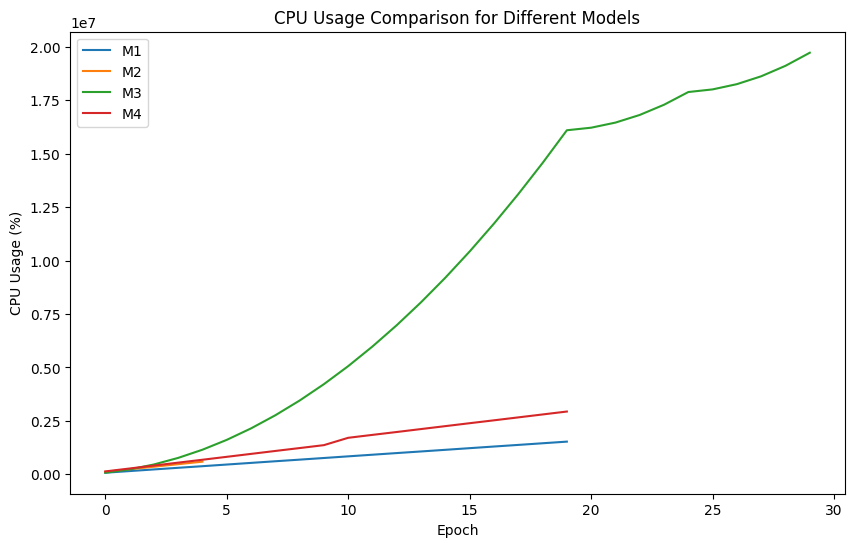

In [ ]:
# prompt: plot กราฟเปรียบเทียบการใช้งาน cpu กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv epoch

import pandas as pd
import matplotlib.pyplot as plt


# Extract the CPU usage data for each model
cpu_usage1 = df1['CPU']
cpu_usage2 = df2['CPU']
cpu_usage3 = df3['CPU']
cpu_usage4 = df4['CPU']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cpu_usage1, label='M1')
plt.plot(cpu_usage2, label='M2')
plt.plot(cpu_usage3, label='M3')
plt.plot(cpu_usage4, label='M4')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()

## VIR RAM

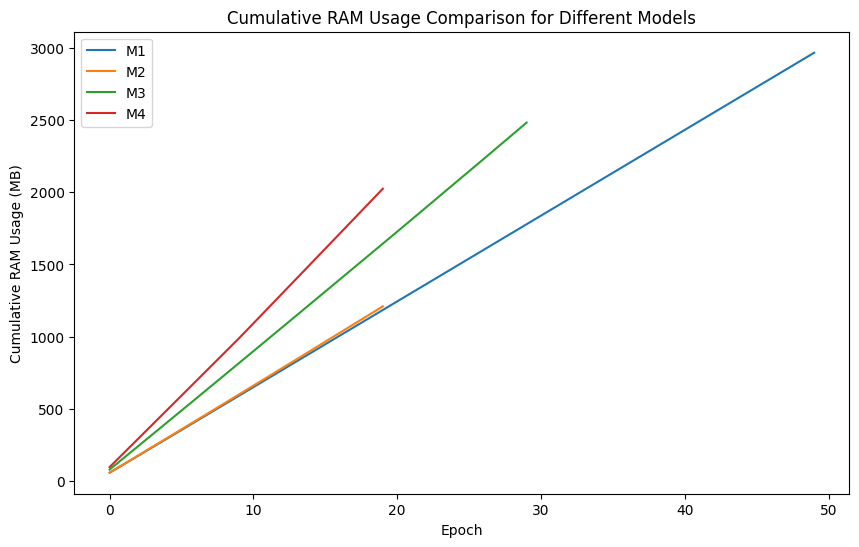

In [ ]:
# prompt: plot กราฟเปรียบเทียบการใช้งาน RAM กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv เมื่อขึ้น epoch ใหม่ให้เอาค่า RAM ก่อนหน้ามารวมกับค่า RAM ปัจจุบันใน epoch นั้น

import matplotlib.pyplot as plt
# Extract the RAM usage data for each model
ram_usage1 = df1['RAM']
ram_usage2 = df2['RAM']
ram_usage3 = df3['RAM']
ram_usage4 = df4['RAM']

# Calculate the cumulative RAM usage for each model
cumulative_ram_usage1 = [sum(ram_usage1[:i+1]) for i in range(len(ram_usage1))]
cumulative_ram_usage2 = [sum(ram_usage2[:i+1]) for i in range(len(ram_usage2))]
cumulative_ram_usage3 = [sum(ram_usage3[:i+1]) for i in range(len(ram_usage3))]
cumulative_ram_usage4 = [sum(ram_usage4[:i+1]) for i in range(len(ram_usage4))]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_ram_usage1, label='M1')
plt.plot(cumulative_ram_usage2, label='M2')
plt.plot(cumulative_ram_usage3, label='M3')
plt.plot(cumulative_ram_usage4, label='M4')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Cumulative RAM Usage (MB)')
plt.title('Cumulative RAM Usage Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()


## VIR LR

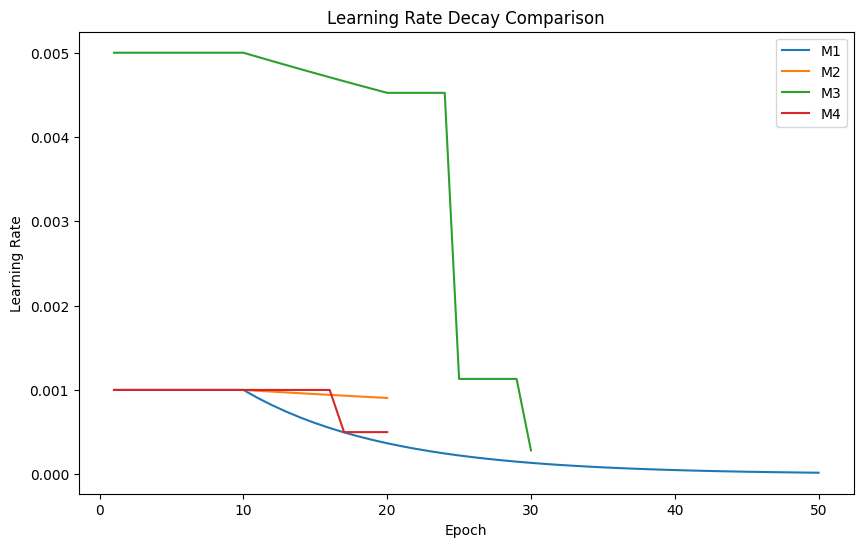

In [ ]:
# prompt: plot กราฟเปรียบเทียบการลดของ learning rate กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv

import pandas as pd
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the learning rate for each model
ax.plot(df1['Epoch Number'], df1['Learning Rate'], label='M1')
ax.plot(df2['Epoch Number'], df2['Learning Rate'], label='M2')
ax.plot(df3['Epoch Number'], df3['Learning Rate'], label='M3')
ax.plot(df4['Epoch Number'], df4['Learning Rate'], label='M4')

# Set the title, axis labels, and legend
ax.set_title('Learning Rate Decay Comparison')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.legend()

# Show the plot
plt.show()


## VIR Training Loss

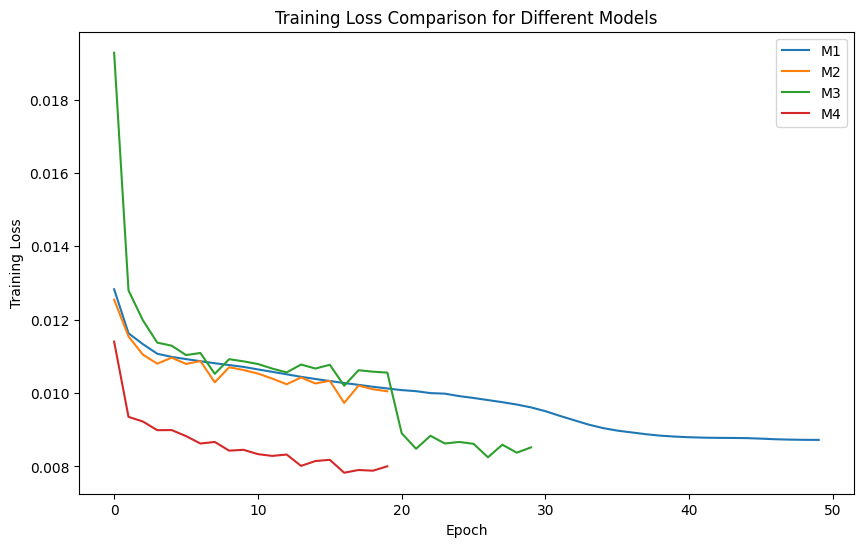

In [ ]:
# prompt: plot กราฟเปรียบเทียบค่า loss กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv

import pandas as pd
import matplotlib.pyplot as plt
# Load the data from the CSV file


# Extract the training loss data for each model
loss1 = df1['Training Loss']
loss2 = df2['Training Loss']
loss3 = df3['Training Loss']
loss4 = df4['Training Loss']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(loss1, label='M1')
plt.plot(loss2, label='M2')
plt.plot(loss3, label='M3')
plt.plot(loss4, label='M4')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()


## VIR Time

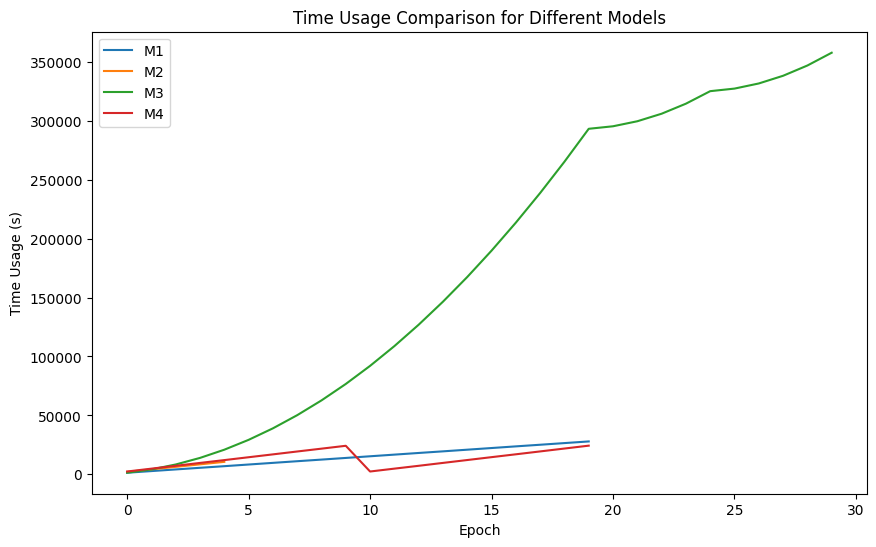

In [ ]:
# prompt: plot กราฟเปรียบเทียบการใช้งาน time กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv

import matplotlib.pyplot as plt
# Extract the time usage data for each model
time_usage1 = df1['Elapsed Time']
time_usage2 = df2['Elapsed Time']
time_usage3 = df3['Elapsed Time']
time_usage4 = df4['Elapsed Time']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_usage1, label='M1')
plt.plot(time_usage2, label='M2')
plt.plot(time_usage3, label='M3')
plt.plot(time_usage4, label='M4')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Time Usage (s)')
plt.title('Time Usage Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()


## VIR MAE

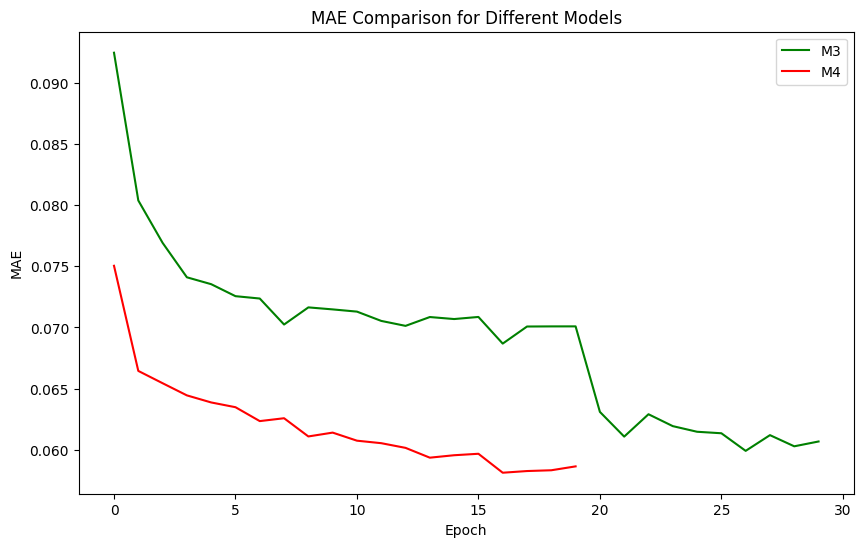

In [ ]:
# prompt: plot กราฟเปรียบเทียบค่า MAE กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv

import pandas as pd
import matplotlib.pyplot as plt

mae3 = df3['MAE']
mae4 = df4['MAE']

# Create the plot
plt.figure(figsize=(10, 6))


plt.plot(mae3, label='M3',color='green')
plt.plot(mae4, label='M4',color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()


## VIR Validate Loss

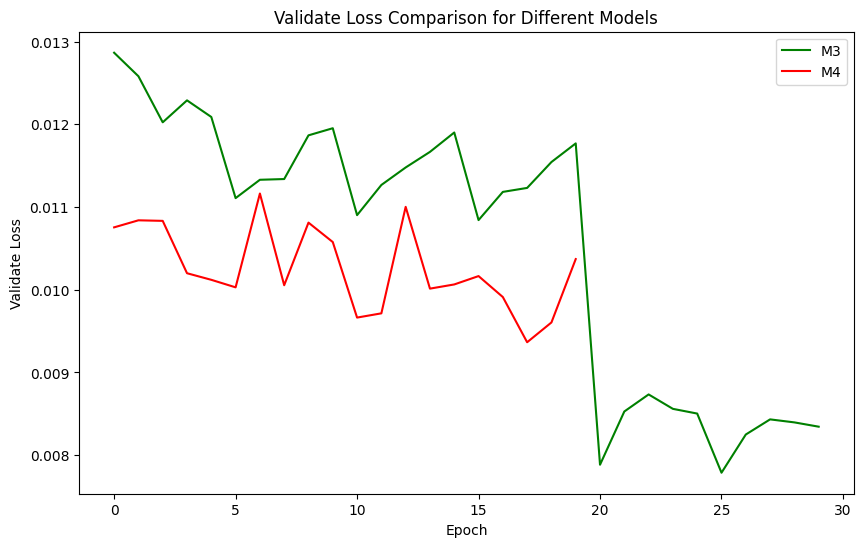

In [ ]:
# prompt: plot กราฟเปรียบเทียบ Validate Loss กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv กำหนดสี

import pandas as pd
import matplotlib.pyplot as plt

# Extract the validation loss data for each model
loss3 = df3['Validate Loss']
loss4 = df4['Validate Loss']

# Create the plot
plt.figure(figsize=(10, 6))


plt.plot(loss3, label='M3', color='green')
plt.plot(loss4, label='M4', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Validate Loss')
plt.title('Validate Loss Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()


## VIR Validate MAE

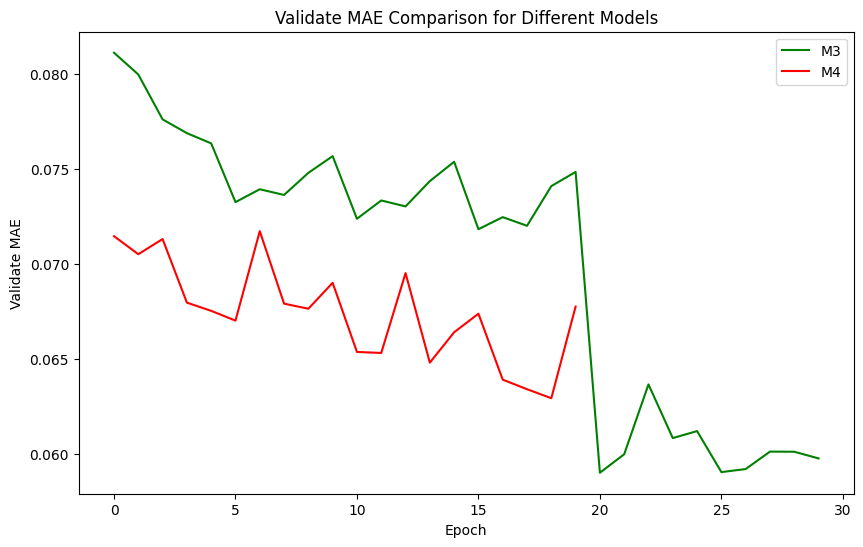

In [ ]:
# prompt: plot กราฟเปรียบเทียบ Validate Loss กับ epoch ของโมเดล 4 ตัว ค่าที่ใช้เอามาจาก csv กำหนดสี

import pandas as pd
import matplotlib.pyplot as plt

# Extract the validation loss data for each model
loss3 = df3['Validate MAE']
loss4 = df4['Validate MAE']

# Create the plot
plt.figure(figsize=(10, 6))


plt.plot(loss3, label='M3', color='green')
plt.plot(loss4, label='M4', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Validate MAE')
plt.title('Validate MAE Comparison for Different Models')

# Add legend and show the plot
plt.legend()
plt.show()
